In [2]:
import os
import random
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import models, transforms


NameError: name 'ImageDraw' is not defined

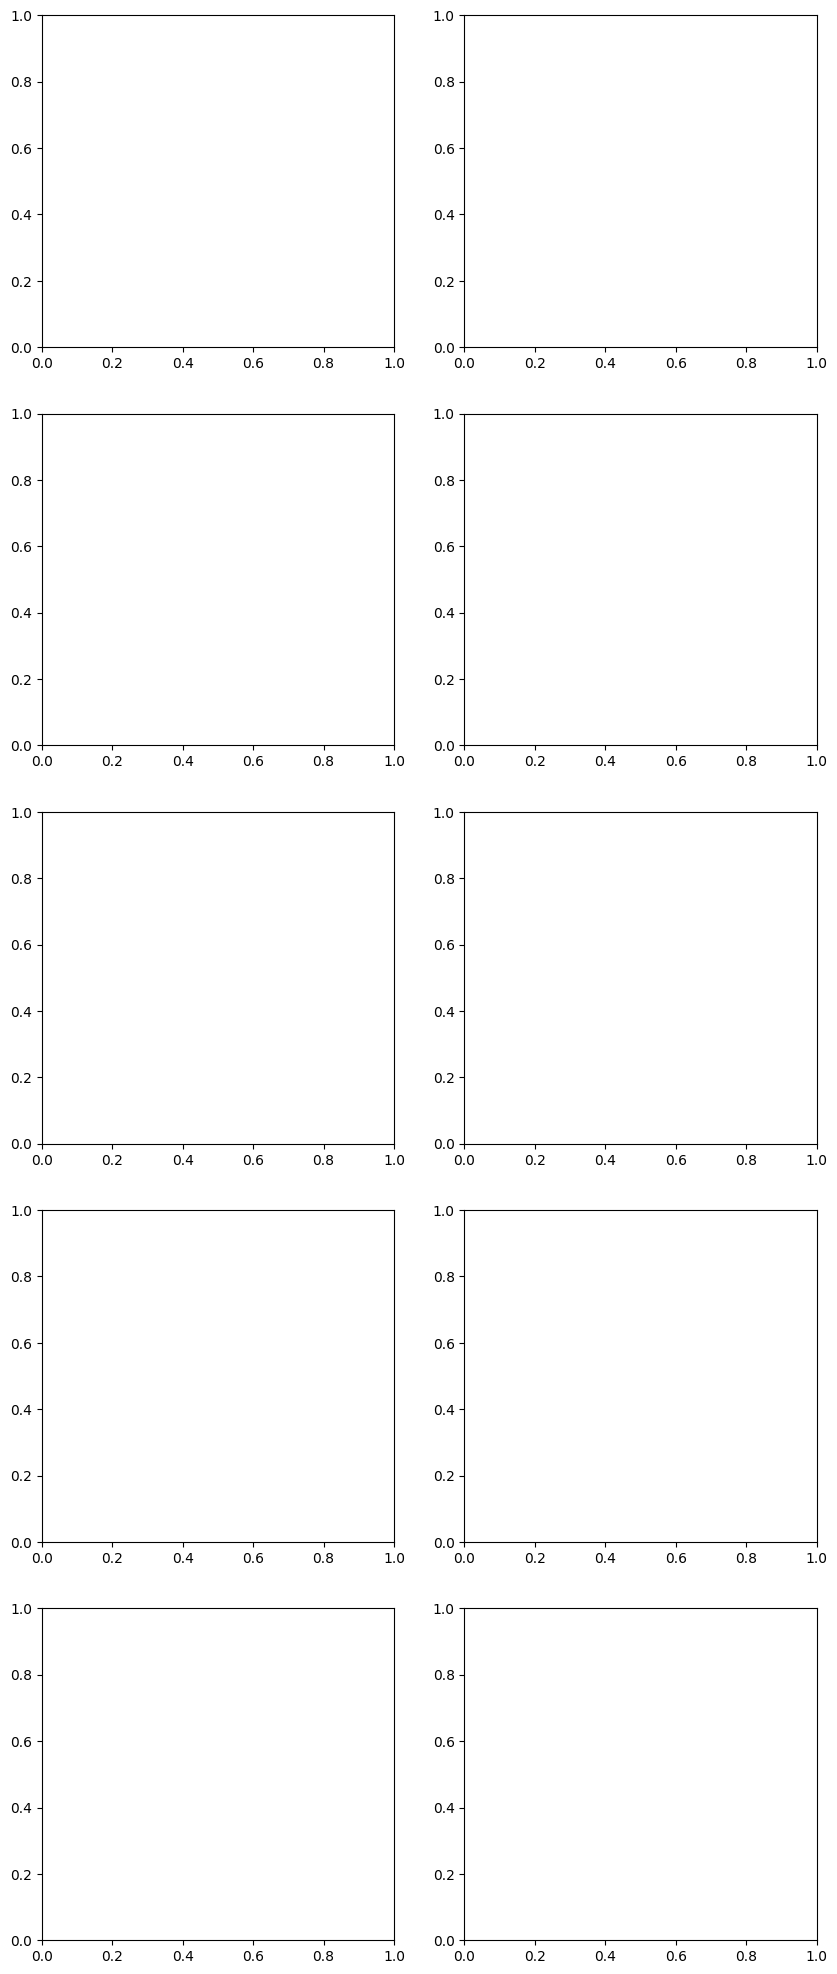

In [3]:
# Set dataset path
dataset_path = "val_256"

# Get all image filenames
image_files = [f for f in os.listdir(dataset_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Select up to 5 random images
num_images_to_show = min(5, len(image_files))
sample_images = random.sample(image_files, num_images_to_show)

def generate_mask(image):
    """Creates a random mask by adding black rectangles over the image."""
    img = image.copy()
    draw = ImageDraw.Draw(img)
    
    # Get image dimensions
    width, height = img.size
    
    # Randomly generate 3-5 rectangles
    num_rectangles = random.randint(3, 5)
    
    for _ in range(num_rectangles):
        x1, y1 = random.randint(0, width // 3), random.randint(0, height // 3)
        x2, y2 = random.randint(width // 3, width), random.randint(height // 3, height)
        
        # Draw a black rectangle (mask)
        draw.rectangle([x1, y1, x2, y2], fill=(0, 0, 0))
    
    return img

# Plot images with masks
fig, axes = plt.subplots(num_images_to_show, 2, figsize=(10, 5 * num_images_to_show))

for i, img_name in enumerate(sample_images):
    img_path = os.path.join(dataset_path, img_name)
    img = Image.open(img_path).convert("RGB")
    masked_img = generate_mask(img)

    # Display original and masked image
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f"Original: {img_name}")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(masked_img)
    axes[i, 1].set_title("Masked Image")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()


In [8]:
import os
import random
import numpy as np
import cv2
import torch
from torchvision import models, transforms
from PIL import Image

# Set dataset path
dataset_path = "val_256"
output_path = "Train_Data"
label_folder = os.path.join(output_path, "Label")
target_folder = os.path.join(output_path, "Target")

# Create output directories
os.makedirs(label_folder, exist_ok=True)
os.makedirs(target_folder, exist_ok=True)

# Get all image filenames in the dataset
image_files = [f for f in os.listdir(dataset_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Sample 5 random images for the demo
num_images_to_show = min(10000, len(image_files))
sample_images = random.sample(image_files, num_images_to_show)

# Load a pretrained Mask R-CNN model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = models.detection.maskrcnn_resnet50_fpn(pretrained=True).to(device)
model.eval()

# Image transformation for Mask R-CNN
transform = transforms.Compose([transforms.ToTensor()])

def detect_objects(image):
    """Runs Mask R-CNN on an image and returns detected object masks."""
    img_tensor = transform(image).to(device)
    with torch.no_grad():
        predictions = model([img_tensor])
    
    # Extract masks, labels, and scores
    masks = predictions[0]['masks'].cpu().numpy()
    labels = predictions[0]['labels'].cpu().numpy()
    scores = predictions[0]['scores'].cpu().numpy()
    
    # Filter objects with confidence > 0.5
    valid_masks = [masks[i][0] for i in range(len(scores)) if scores[i] > 0.5]
    
    return valid_masks  # List of masks

def create_mask_from_segment(image, masks):
    """Randomly selects one detected object and generates a mask."""
    height, width, _ = image.shape
    
    if len(masks) == 0:
        # If no objects are detected, generate a random rectangular mask
        mask = np.zeros((height, width), dtype=np.uint8)
        x1, y1 = random.randint(0, width // 2), random.randint(0, height // 2)
        x2, y2 = random.randint(width // 2, width), random.randint(height // 2, height)
        cv2.rectangle(mask, (x1, y1), (x2, y2), 255, -1)  # White filled rectangle
        return mask

    # Select a random object
    selected_mask = random.choice(masks)

    # Convert mask to binary
    selected_mask = (selected_mask > 0.5).astype(np.uint8) * 255

    # Apply dilation for smoother inpainting
    kernel_size = random.randint(5, 30)
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    dilated_mask = cv2.dilate(selected_mask, kernel, iterations=1)

    return dilated_mask

def apply_mask(image, mask):
    """Applies the mask by setting selected areas to black."""
    masked_image = image.copy()
    masked_image[mask > 0] = [0, 0, 0]  # Set masked area to black
    return masked_image

# Process and save images
for i, img_name in enumerate(sample_images):
    img_path = os.path.join(dataset_path, img_name)
    image = np.array(Image.open(img_path).convert("RGB"))

    # Detect objects using Mask R-CNN
    masks = detect_objects(image)

    # Generate a mask for a random object or random region if no objects detected
    object_mask = create_mask_from_segment(image, masks)

    # Apply the mask
    masked_image = apply_mask(image, object_mask)

    # Save images
    target_path = os.path.join(target_folder, f"target{i}.jpg")
    label_path = os.path.join(label_folder, f"label{i}.jpg")
    
    Image.fromarray(image).save(target_path)
    Image.fromarray(masked_image).save(label_path)

print(f"Processed {num_images_to_show} images. Output saved in '{output_path}' directory.")


Processed 10000 images. Output saved in 'Train_Data' directory.
